In [1]:
import joblib
import pandas as pd
from os.path import join
import numpy as np
#from ml_workflow.ml_workflow.ml_methods import norm_aupdc, brier_skill_score
from sklearn.metrics import roc_auc_score

import sys
sys.path.insert(0, '/home/monte.flora/python_packages/master/ml_workflow')

In [2]:
known_skew = {'first_hour': {'severe_hail': 0.0391880873707248,
  'severe_wind': 0.027375770765324627,
  'tornado': 0.012250931885049705},
 'second_hour': {'severe_hail': 0.03567197119293762,
  'severe_wind': 0.02379619369012823,
  'tornado': 0.009605216107852312}}

In [3]:
lead_time = 'second_hour'
target = 'tornado'

new_model = False
old_test = False

if new_model:
    path = f'/work/mflora/ML_DATA/new_models/LogisticRegression_{lead_time}_{target}_under_standard_.pkl'
else:
    path = f'/work/mflora/ML_DATA/MODEL_SAVES/LogisticRegression_{lead_time}_{target}_under_standard_.pkl'

try:
    data = joblib.load(path)
except:
    path = f'/work/mflora/ML_DATA/MODEL_SAVES/LogisticRegression_{lead_time}_{target}_None_standard_.pkl' 
    data = joblib.load(path)

    clf = data['model']
features = data['features']

if old_test:
    test_df = pd.read_feather(
    f'/work/mflora/ML_DATA/DATA/original_{lead_time}_testing_matched_to_{target}_0km_data.feather')
else:
    # Load just 2020-2021
    years =  ['2021'] #['2020', '2021']
    path = '/work/mflora/ML_DATA/DATA'
    test_df_list = [pd.read_pickle(join(path, 
                        f'ml_dataset_{lead_time}_{year}_reverted_names.pkl')).astype(float,errors='ignore')
           for year in years]
            
    test_df = pd.concat(test_df_list, axis=0)
    test_df.reset_index(inplace=True, drop=True)
    
    #path = '/work/mflora/ML_DATA/test_data'
    #test_df = pd.read_feather(join(path, f'test_ml_dataset_{lead_time}_{target}.feather'))
    
X_test = test_df[features].astype(float)
y_test = test_df[f'matched_to_{target}_0km'].astype(float)

X_test_copy = X_test.copy()

# Convert cloud-top temps from F to C 
ctt_vars = [c for c in test_df.columns if 'cloud_top_temp' in c and 'ens_mean' in c]
for c in ctt_vars:
    X_test_copy[c] = (5./9.) * (X_test[c] - 32.)

/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from vers

In [4]:
from sklearn.metrics import brier_score_loss
def brier_skill_score(y_values, forecast_probabilities, **kwargs):
    """Computes the brier skill score"""
    known_skew = kwargs.get('known_skew', np.mean(y_values))
    climo = np.mean((y_values - known_skew) ** 2)
    return 1.0 - brier_score_loss(y_values, forecast_probabilities) / climo

In [5]:
from ml_workflow.ml_methods import norm_aupdc

def scorer(model, X, y, known_skew):
    naupdc = []
    bss = [] 
    auc = []
    for n in range(30):
        inds = np.random.choice(len(X), size=int(len(X)*0.75))
        X_i = X.iloc[inds, :]
        y_i = y[inds]
        predictions = model.predict_proba(X_i)[:,1]
        naupdc.append(norm_aupdc(y_i, predictions, known_skew=known_skew))
        bss.append(brier_skill_score(y_i, predictions, known_skew=known_skew))
        auc.append(roc_auc_score(y_i, predictions))
        
    print( f'NAUPDC: {np.mean(naupdc):.03f} | BSS : {np.mean(bss):.03f} | AUC : {np.mean(auc):.03f}')

In [6]:
scorer(clf, X_test_copy.astype(float), y_test.values, known_skew[lead_time][target])

NAUPDC: 0.132 | BSS : 0.050 | AUC : 0.936


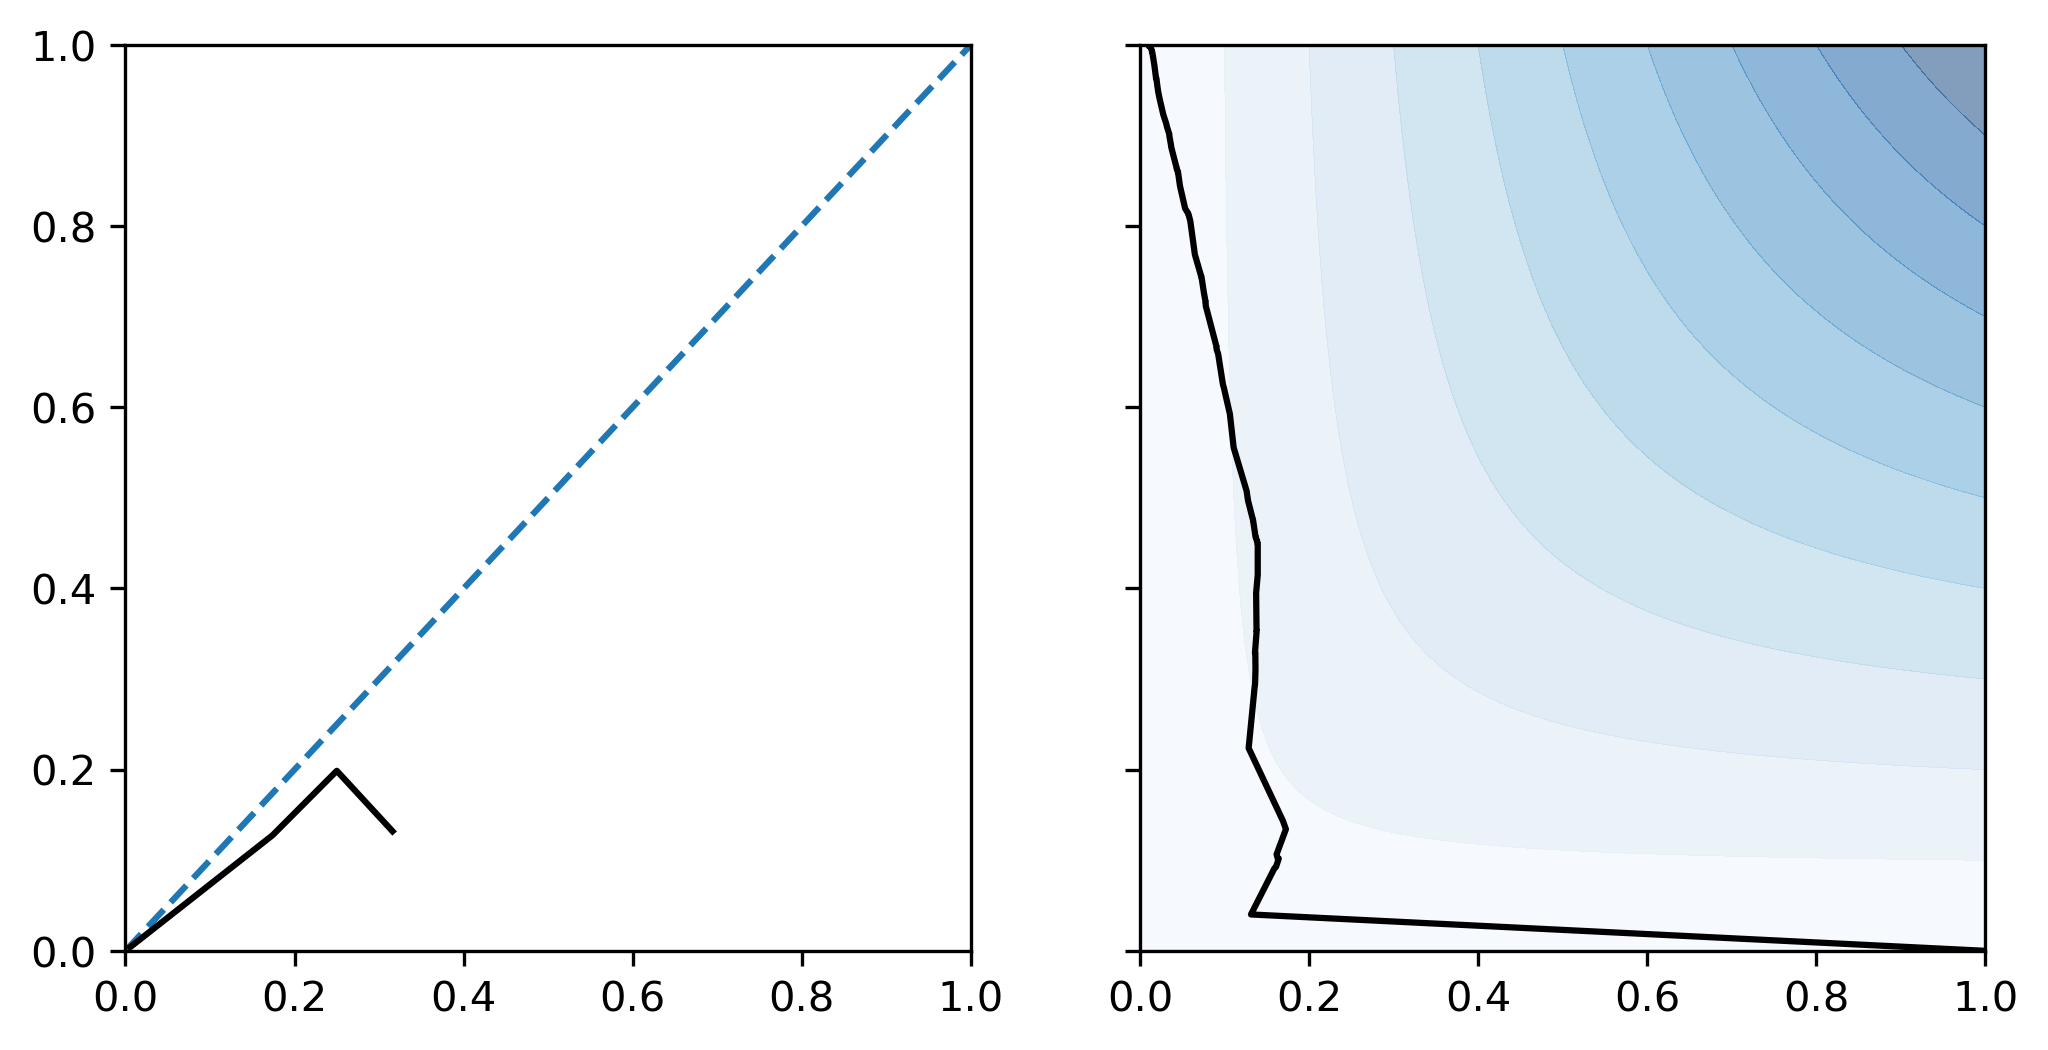

In [7]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_pred = clf.predict_proba(X_test_copy)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
sr, pod, _ = precision_recall_curve(y_test, y_pred)

f, axes = plt.subplots(ncols=2, dpi=300, sharey=True, figsize=(8,4))

for i, (ax, x, y) in enumerate(zip(axes.flat, [prob_pred, sr], [prob_true, pod])):
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    if i == 0:
        ax.plot([0,1], [0,1], ls='dashed')
    else:
        xx = np.linspace(0.001, 1,100)
        yy = xx
        xx,yy = np.meshgrid(xx,xx)
        csi = 1 / (1/xx + 1/yy -1)
        ax.contourf(xx,yy,csi, cmap='Blues', alpha=0.5, levels=np.arange(0,1.1,0.1))
        
    ax.plot(x,y, color='k')

In [8]:
sys.path.append('/home/monte.flora/python_packages/wofs_ml_severe/wofs_ml_severe/explain')
sys.path.append('/home/monte.flora/python_packages/scikit-explain')

from display_names import to_readable_names, get_units

feature_names = X_test_copy.columns
display_feature_names = {f : to_readable_names(f) for f in feature_names}
display_units = {f : get_units(f) for f in feature_names}